<center><h1> hold-out average : a post-solar testing method </h1></center>

# In this file, we show the detailed step and resut of hold-out average and compare it with classical post-OLS tests and the overfitting post-FR tests

In [1]:
%reset -f

In [2]:
import itertools
import time
import pickle

import numpy             as np
import pandas            as pd
import seaborn           as sns
import statsmodels.api   as sm
import matplotlib.pyplot as plt

from sklearn         import linear_model
from sklearn.metrics import mean_squared_error
from tqdm            import tqdm_notebook
from tqdm.notebook   import trange
from tqdm            import tqdm
from solar           import solar

# fix random seeds

In [3]:
np.random.seed(0)

# define data generator for simulation (copied from "simulator.py")

In [4]:
def data_gen(sample_size, n_dim, n_info):  
  
    ############ generate data #################
    ##1. generating the covariance matrix for X,
    #we add a matrix full of 1/2 with an identity matrix multiplied with 1/2
    a     = np.ones((n_dim, n_dim)) * 0.5
    A     = np.eye(n_dim)*0.5
    cov_x = a + A
    ##2. generating the mean of each column in X (which is 0)
    mean_x = np.zeros(n_dim)
    ##3. generating X as a multivariate Gaussian
    X_org = np.random.multivariate_normal(mean_x, cov_x, sample_size)
    ##4. generate regression coefficients in DGP as an increasing sequence (2,3,4,5,6 in our paper)
    beta_info = np.arange(2, n_info + 2)
    #in DGP, generate regression coefficients of redundant variables as 0
    #concatenate the regression coefficients of informative variables and redundant variables
    beta = np.concatenate((beta_info, np.zeros(n_dim - n_info)), axis = 0)
    ##5. generate the Gaussian random noise
    noise = np.random.normal(0, 1, sample_size)
    #transform Gaussian random noise into a column
    #transform regression coefficients in DGP into a row (based on the requirement of np.inner )
    noise.shape = (sample_size, 1); beta.shape = (1, n_dim)
    ##6. generate Y by adding random noise with the inner product of X and beta
    Y_org = np.inner(X_org,beta) + noise

    return X_org, Y_org

# define the OLS fitting function for the forward regression module

In [5]:
def fit_linear_reg(X,Y):
    #Fit linear regression model and return RSS and R squared values
    model_k = linear_model.LinearRegression(fit_intercept = True)
    model_k.fit(X,Y)
    RSS = mean_squared_error(Y,model_k.predict(X)) * len(Y)
    R_squared = model_k.score(X,Y)
    return RSS, R_squared

# generate a sample with corresponding variable names based on the following DGP

* <font size="4.5"> the population regression equation is $$Y = 2\cdot \mathbf{x}_0 + 3\cdot \mathbf{x}_1 + 4\cdot \mathbf{x}_2 + 5\cdot \mathbf{x}_3 + 6\cdot \mathbf{x}_4  + y,$$ 
* <font size="4.5"> To change the simulation settings, simply change the input values. If you change *n_info* you will adjust the DGP as follows: </font>
    * <font size="4.5"> If $i > \mbox{n_info} - 1$ and $i \in \left[ 0, 1, 2, \ldots, p-1 \right]$, $\beta_i = 0$ in population;</font>
    * <font size="4.5"> If $i \leqslant \mbox{n_info} - 1$ and $i \in \left[ 0, 1, 2, \ldots, p-1 \right]$, $\beta_i = i + 2$ in population</font>

In [6]:
sample_size = 100
n_dim       = 50
n_info      = 5

X_org, Y_org = data_gen(sample_size, n_dim, n_info)

In [7]:
var_name = ['X' + str(i) for i in np.arange(0,50)]
print(var_name)

['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40', 'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49']


# set X and Y as dataframe tables and check the head of each table

In [8]:
X = pd.DataFrame(X_org, columns=var_name)
X.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49
0,-0.418119,-2.484500,-2.216060,0.261566,-0.616118,-0.135419,-1.506387,-0.315226,-1.139980,-1.778351,...,-0.416747,-1.038728,-0.042607,-0.572763,-2.051329,-2.195759,-1.011730,-0.771535,-2.897940,0.434637
1,0.513544,0.957188,0.136571,0.666413,0.123045,1.497550,1.998191,0.061466,0.752747,1.154928,...,0.317298,1.105867,1.526684,1.339478,0.783389,0.663594,2.160402,-0.495298,-0.543264,0.350301
2,-1.490648,-1.393497,-1.380175,-0.967975,-0.286726,-0.427648,-1.128860,-1.141304,-2.509236,-1.690238,...,-0.642017,-2.011324,-2.730125,-0.713984,-2.012598,-1.065123,-1.853763,-1.191532,-1.953416,-2.113132
3,0.085250,0.983824,-0.128196,-0.182646,1.300703,-0.526388,0.831146,-0.833137,0.396672,1.535557,...,0.474225,0.560223,-0.195938,0.051744,-0.764848,-0.203560,1.965447,1.285703,0.233716,-0.108280
4,-1.185341,0.107799,1.160532,1.127312,-0.067161,0.206282,0.830086,1.057223,0.524590,-0.209415,...,0.316513,0.439864,-0.112185,-0.118517,-0.055310,0.590799,0.483812,0.317342,-0.544142,0.181375


In [9]:
Y = pd.DataFrame(Y_org, columns=['Y'])
Y.head()

,Y
0,-19.233137
1,7.777820
2,-20.779636
3,8.937923
4,6.228926


# run forward regression (FR) on the sample and report the result

In [10]:
# total steps of forward regression
k = 20

#Initialization variables
remaining_features = list(X.columns.values)
features = []
#Due to 1 indexing of the loop...
RSS_list, R_squared_list = [np.inf], [np.inf]
features_list = dict()

for i in range(1,k+1):
    best_RSS = np.inf

    for combo in itertools.combinations(remaining_features,1):

        #Store temp result 
        RSS = fit_linear_reg(X[list(combo) + features],Y)   

        if RSS[0] < best_RSS:
            best_RSS = RSS[0]
            best_R_squared = RSS[1] 
            best_feature = combo[0]

    #Updating variables for next loop
    features.append(best_feature)
    remaining_features.remove(best_feature)

    #Saving values for plotting
    RSS_list.append(best_RSS)
    R_squared_list.append(best_R_squared)
    features_list[i] = features.copy()

In [11]:
print('Forward stepwise subset selection')
print('Number of features |', 'Features |', 'RSS')
display([(i,features_list[i], round(RSS_list[i])) for i in range(1,20)])

Forward stepwise subset selection
Number of features | Features | RSS


[(1, ['X4'], 6936),
 (2, ['X4', 'X3'], 2895),
 (3, ['X4', 'X3', 'X2'], 959),
 (4, ['X4', 'X3', 'X2', 'X1'], 403),
 (5, ['X4', 'X3', 'X2', 'X1', 'X0'], 107),
 (6, ['X4', 'X3', 'X2', 'X1', 'X0', 'X45'], 99),
 (7, ['X4', 'X3', 'X2', 'X1', 'X0', 'X45', 'X8'], 93),
 (8, ['X4', 'X3', 'X2', 'X1', 'X0', 'X45', 'X8', 'X40'], 88),
 (9, ['X4', 'X3', 'X2', 'X1', 'X0', 'X45', 'X8', 'X40', 'X6'], 82),
 (10, ['X4', 'X3', 'X2', 'X1', 'X0', 'X45', 'X8', 'X40', 'X6', 'X39'], 78),
 (11,
  ['X4', 'X3', 'X2', 'X1', 'X0', 'X45', 'X8', 'X40', 'X6', 'X39', 'X11'],
  73),
 (12,
  ['X4',
   'X3',
   'X2',
   'X1',
   'X0',
   'X45',
   'X8',
   'X40',
   'X6',
   'X39',
   'X11',
   'X34'],
  70),
 (13,
  ['X4',
   'X3',
   'X2',
   'X1',
   'X0',
   'X45',
   'X8',
   'X40',
   'X6',
   'X39',
   'X11',
   'X34',
   'X5'],
  66),
 (14,
  ['X4',
   'X3',
   'X2',
   'X1',
   'X0',
   'X45',
   'X8',
   'X40',
   'X6',
   'X39',
   'X11',
   'X34',
   'X5',
   'X9'],
  63),
 (15,
  ['X4',
   'X3',
   'X2',
   'X

# summarize it into a nice-looking table

In [12]:
df1 = pd.concat([pd.DataFrame({'features':features_list}),pd.DataFrame({'RSS':RSS_list, 'R_squared': R_squared_list})], axis=1, join='inner')
df1['numb_features'] = df1.index

In [13]:
#Initializing useful variables
m = len(Y)
p = 11
hat_sigma_squared = (1/(m - p -1)) * min(df1['RSS'])

#Computing
df1['C_p'] = (1/m) * (df1['RSS'] + 2 * df1['numb_features'] * hat_sigma_squared )
df1['AIC'] = (1/(m*hat_sigma_squared)) * (df1['RSS'] + 2 * df1['numb_features'] * hat_sigma_squared )
df1['BIC'] = (1/(m*hat_sigma_squared)) * (df1['RSS'] +  np.log(m) * df1['numb_features'] * hat_sigma_squared )
df1['R_squared_adj'] = 1 - ( (1 - df1['R_squared'])*(m-1)/(m-df1['numb_features'] -1))

#set up the table
df1

,features,RSS,R_squared,numb_features,C_p,AIC,BIC,R_squared_adj
1,[X4],6935.967867,0.690740,1,69.371966,112.919120,112.945172,0.687585
2,"[X4, X3]",2895.019623,0.870917,2,28.974770,47.163224,47.215328,0.868256
3,"[X4, X3, X2]",959.048334,0.957238,3,9.627344,15.670758,15.748913,0.955902
4,"[X4, X3, X2, X1]",402.806404,0.982040,4,4.077212,6.636618,6.740824,0.981284
5,"[X4, X3, X2, X1, X0]",107.120014,0.995224,5,1.132635,1.843629,1.973888,0.994970
6,"[X4, X3, X2, X1, X0, X45]",99.278343,0.995573,6,1.066506,1.735988,1.892298,0.995288
7,"[X4, X3, X2, X1, X0, X45, X8]",93.201596,0.995844,7,1.018025,1.657074,1.839436,0.995528
8,"[X4, X3, X2, X1, X0, X45, X8, X40]",87.693842,0.996090,8,0.975235,1.587423,1.795836,0.995746
9,"[X4, X3, X2, X1, X0, X45, X8, X40, X6]",82.432024,0.996325,9,0.934903,1.521774,1.756240,0.995957
10,"[X4, X3, X2, X1, X0, X45, X8, X40, X6, X39]",78.309167,0.996508,10,0.905962,1.474665,1.735182,0.996116


In [14]:
BIC_min = np.where(np.array(df1['BIC']) == min(np.array(df1['BIC'])))[0][0]
print("the minimal BIC score is displayed at step", BIC_min)

the minimal BIC score is displayed at step 13


# the one with minimal BIC is row 13

In [15]:
features_list[BIC_min]

['X4',
 'X3',
 'X2',
 'X1',
 'X0',
 'X45',
 'X8',
 'X40',
 'X6',
 'X39',
 'X11',
 'X34',
 'X5']

# compute post-FR t-value and p-value

In [16]:
XX_0 = X[features_list[BIC_min]]
YY_0 = Y
XX_0 = sm.add_constant(XX_0)
reg0 = sm.OLS(YY_0, XX_0)

result0 = reg0.fit()
print(result0.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     2231.
Date:                Mon, 12 Apr 2021   Prob (F-statistic):          8.57e-103
Time:                        20:09:31   Log-Likelihood:                -121.35
No. Observations:                 100   AIC:                             270.7
Df Residuals:                      86   BIC:                             307.2
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1651      0.097     -1.703      0.0

# compute classical OLS t value and p-value as the benchmark

In [17]:
XX_1 = X
YY_1 = Y
XX_1 = sm.add_constant(XX_1)
reg1 = sm.OLS(YY_1, XX_1)

result1 = reg1.fit()
print(result1.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     477.0
Date:                Mon, 12 Apr 2021   Prob (F-statistic):           5.96e-53
Time:                        20:09:31   Log-Likelihood:                -103.05
No. Observations:                 100   AIC:                             308.1
Df Residuals:                      49   BIC:                             441.0
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0850      0.156     -0.546      0.5

# solar selection

In [18]:
n_repeat = 10
step_size = -0.02

In [19]:
np.random.seed(0)

# train solar
trial2 = solar(X_org, Y_org, n_repeat, step_size, lasso=False)

solar_coef, opt_c, test_error, Qc_list, Q_opt_c, _, _, _, _ = trial2.fit()


print('variables that solar selects: ', Q_opt_c)

variables that solar selects:  [0, 1, 2, 3, 4, 40, 45]


# post-solar hold-out average

In [20]:
X_half_1 = X_org[0:50,:]
Y_half_1 = Y_org[0:50,:]
X_half_2 = X_org[50:100,:]
Y_half_2 = Y_org[50:100,:]

X_half_1 = pd.DataFrame(X_half_1, columns=var_name)
Y_half_1 = pd.DataFrame(Y_half_1, columns=['Y'])
X_half_2 = pd.DataFrame(X_half_2, columns=var_name)
Y_half_2 = pd.DataFrame(Y_half_2, columns=['Y'])

## first half result

In [21]:
active_var = ['X' + str(i) for i in Q_opt_c]
XX_half_1 = X_half_1[active_var]
YY_half_1 = Y_half_1
XX_half_1 = sm.add_constant(XX_half_1)
reg_half_1 = sm.OLS(YY_half_1, XX_half_1)

result_half_1 = reg_half_1.fit()
print(result_half_1.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     1314.
Date:                Mon, 12 Apr 2021   Prob (F-statistic):           4.72e-47
Time:                        20:09:31   Log-Likelihood:                -68.574
No. Observations:                  50   AIC:                             153.1
Df Residuals:                      42   BIC:                             168.4
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0931      0.167     -0.559      0.5

## second half result

In [22]:
active_var = ['X' + str(i) for i in Q_opt_c]
XX_half_2 = X_half_2[active_var]
YY_half_2 = Y_half_2
XX_half_2 = sm.add_constant(XX_half_2)
reg_half_2 = sm.OLS(YY_half_2, XX_half_2)

result_half_2 = reg_half_2.fit()
print(result_half_2.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     2004.
Date:                Mon, 12 Apr 2021   Prob (F-statistic):           6.97e-51
Time:                        20:09:31   Log-Likelihood:                -63.464
No. Observations:                  50   AIC:                             142.9
Df Residuals:                      42   BIC:                             158.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0516      0.147     -0.352      0.7

# hold-out average

In [23]:
#hold-out average t-value
X0_t = (result_half_1.tvalues[1] + result_half_2.tvalues[1])/2
X1_t = (result_half_1.tvalues[2] + result_half_2.tvalues[2])/2
X2_t = (result_half_1.tvalues[3] + result_half_2.tvalues[3])/2
X3_t = (result_half_1.tvalues[4] + result_half_2.tvalues[4])/2
X4_t = (result_half_1.tvalues[5] + result_half_2.tvalues[5])/2
X40_t = (result_half_1.tvalues[6] + result_half_2.tvalues[6])/2
X45_t = (result_half_1.tvalues[7] + result_half_2.tvalues[7])/2
#hold-out average p-value
X0_p = (result_half_1.pvalues[1] + result_half_2.pvalues[1])/2
X1_p = (result_half_1.pvalues[2] + result_half_2.pvalues[2])/2
X2_p = (result_half_1.pvalues[3] + result_half_2.pvalues[3])/2
X3_p = (result_half_1.pvalues[4] + result_half_2.pvalues[4])/2
X4_p = (result_half_1.pvalues[5] + result_half_2.pvalues[5])/2
X40_p = (result_half_1.pvalues[6] + result_half_2.pvalues[6])/2
X45_p = (result_half_1.pvalues[7] + result_half_2.pvalues[7])/2
#hold-out average se
X0_se = (result_half_1.bse[1] + result_half_2.bse[1])/2
X1_se = (result_half_1.bse[2] + result_half_2.bse[2])/2
X2_se = (result_half_1.bse[3] + result_half_2.bse[3])/2
X3_se = (result_half_1.bse[4] + result_half_2.bse[4])/2
X4_se = (result_half_1.bse[5] + result_half_2.bse[5])/2
X40_se = (result_half_1.bse[6] + result_half_2.bse[6])/2
X45_se = (result_half_1.bse[7] + result_half_2.bse[7])/2

# summarize it into a nice-looking table

In [24]:
df_hor = pd.concat([pd.DataFrame({'variable name':active_var}), pd.DataFrame({'se':[X0_se, X1_se, X2_se, X3_se, X4_se, X40_se, X45_se],'t-val':[X0_t, X1_t, X2_t, X3_t, X4_t, X40_t, X45_t], 'p-val': [X0_p, X1_p, X2_p, X3_p, X4_p, X40_p, X45_p]})], axis=1, join='inner')

df_hor.round(4)

,variable name,se,t-val,p-val
0,X0,0.1812,11.3461,0.0000
1,X1,0.2153,12.7568,0.0000
2,X2,0.2132,18.2223,0.0000
3,X3,0.2025,24.4836,0.0000
4,X4,0.2084,27.3678,0.0000
5,X40,0.1891,1.9029,0.1869
6,X45,0.2112,1.1899,0.2510


# Now let's automate everything above for 200 repetitions

In [25]:
np.random.seed(0)

In [26]:
def simul_func():
  
    ############ lists #################

    X0_t = list()
    X1_t = list()
    X2_t = list()
    X3_t = list()
    X4_t = list()
    X0_p = list()
    X1_p = list()
    X2_p = list()
    X3_p = list()
    X4_p = list()
    X0_se = list()
    X1_se = list()
    X2_se = list()
    X3_se = list()
    X4_se = list()

    X0_t_FR = list()
    X1_t_FR = list()
    X2_t_FR = list()
    X3_t_FR = list()
    X4_t_FR = list()
    X0_p_FR = list()
    X1_p_FR = list()
    X2_p_FR = list()
    X3_p_FR = list()
    X4_p_FR = list()
    X0_se_FR = list()
    X1_se_FR = list()
    X2_se_FR = list()
    X3_se_FR = list()
    X4_se_FR = list()

    X0_t_OLS = list()
    X1_t_OLS = list()
    X2_t_OLS = list()
    X3_t_OLS = list()
    X4_t_OLS = list()
    X0_p_OLS = list()
    X1_p_OLS = list()
    X2_p_OLS = list()
    X3_p_OLS = list()
    X4_p_OLS = list()
    X0_se_OLS = list()
    X1_se_OLS = list()
    X2_se_OLS = list()
    X3_se_OLS = list()
    X4_se_OLS = list()

    for i in tqdm(range(0,200)):

        X_org, Y_org = data_gen(100, 50, 10)

        ############ Post-FR OLS #################

        k = 20

        var_name = ['X' + str(i) for i in np.arange(0,50)]
        X = pd.DataFrame(X_org, columns=var_name)
        Y = pd.DataFrame(Y_org, columns=['Y'])

        #Initialization variables
        remaining_features = list(X.columns.values)
        features = []
        #Due to 1 indexing of the loop...
        RSS_list, R_squared_list = [np.inf], [np.inf]
        features_list = dict()

        for i in range(1,k+1):
            best_RSS = np.inf

            for combo in itertools.combinations(remaining_features,1):

                #Store temp result 
                RSS = fit_linear_reg(X[list(combo) + features],Y)   


                if RSS[0] < best_RSS:
                    best_RSS = RSS[0]
                    best_R_squared = RSS[1] 
                    best_feature = combo[0]

            #Updating variables for next loop
            features.append(best_feature)
            remaining_features.remove(best_feature)

            #Saving values for plotting
            RSS_list.append(best_RSS)
            R_squared_list.append(best_R_squared)
            features_list[i] = features.copy()

        BIC_min = np.where(np.array(df1['BIC']) == min(np.array(df1['BIC'])))[0][0]
        XX_0 = X[features_list[BIC_min]]
        YY_0 = Y
        XX_0 = sm.add_constant(XX_0)
        reg0 = sm.OLS(YY_0, XX_0)

        result0 = reg0.fit()

        #OLS t-value
        X0_t_FR.append(result0.tvalues[1])
        X1_t_FR.append(result0.tvalues[2])
        X2_t_FR.append(result0.tvalues[3])
        X3_t_FR.append(result0.tvalues[4])
        X4_t_FR.append(result0.tvalues[5])
        #OLS p-value
        X0_p_FR.append(result0.pvalues[1])
        X1_p_FR.append(result0.pvalues[2])
        X2_p_FR.append(result0.pvalues[3])
        X3_p_FR.append(result0.pvalues[4])
        X4_p_FR.append(result0.pvalues[5])
        #OLS se
        X0_se_FR.append(result0.bse[1])
        X1_se_FR.append(result0.bse[2])
        X2_se_FR.append(result0.bse[3])
        X3_se_FR.append(result0.bse[4])
        X4_se_FR.append(result0.bse[5])

        ############ OLS #################
        XX_1 = X_org
        YY_1 = Y_org
        XX_1 = sm.add_constant(XX_1)
        reg1 = sm.OLS(YY_1, XX_1)
        result1 = reg1.fit()

        #OLS t-value
        X0_t_OLS.append(result1.tvalues[1])
        X1_t_OLS.append(result1.tvalues[2])
        X2_t_OLS.append(result1.tvalues[3])
        X3_t_OLS.append(result1.tvalues[4])
        X4_t_OLS.append(result1.tvalues[5])
        #OLS p-value
        X0_p_OLS.append(result1.pvalues[1])
        X1_p_OLS.append(result1.pvalues[2])
        X2_p_OLS.append(result1.pvalues[3])
        X3_p_OLS.append(result1.pvalues[4])
        X4_p_OLS.append(result1.pvalues[5])
        #OLS se
        X0_se_OLS.append(result1.bse[1])
        X1_se_OLS.append(result1.bse[2])
        X2_se_OLS.append(result1.bse[3])
        X3_se_OLS.append(result1.bse[4])
        X4_se_OLS.append(result1.bse[5])

        ###### post-solar hold-out average ###########

        trial2 = solar(X_org, Y_org, 10, -0.01, lasso=False)

        _, _, _, _, Q_opt_c, _, _, _, _ = trial2.fit()

        #### 2 halves of the hold-out ####
        active_var = ['X' + str(i) for i in Q_opt_c]
        X_half_1 = X_org[0:50,:]
        Y_half_1 = Y_org[0:50,:]
        X_half_2 = X_org[50:100,:]
        Y_half_2 = Y_org[50:100,:]

        X_half_1 = pd.DataFrame(X_half_1, columns=var_name)
        Y_half_1 = pd.DataFrame(Y_half_1, columns=['Y'])
        X_half_2 = pd.DataFrame(X_half_2, columns=var_name)
        Y_half_2 = pd.DataFrame(Y_half_2, columns=['Y'])

        #first half OLS
        XX_half_1 = X_half_1[active_var]
        YY_half_1 = Y_half_1
        XX_half_1 = sm.add_constant(XX_half_1)
        reg_half_1 = sm.OLS(YY_half_1, XX_half_1)
        result_half_1 = reg_half_1.fit()

        #second half OLS
        XX_half_2 = X_half_2[active_var]
        YY_half_2 = Y_half_2
        XX_half_2 = sm.add_constant(XX_half_2)
        reg_half_2 = sm.OLS(YY_half_2, XX_half_2)
        result_half_2 = reg_half_2.fit()

        #hold-out average
        X0_t.append((result_half_1.tvalues[1] + result_half_2.tvalues[1])/2)
        X1_t.append((result_half_1.tvalues[2] + result_half_2.tvalues[2])/2)
        X2_t.append((result_half_1.tvalues[3] + result_half_2.tvalues[3])/2)
        X3_t.append((result_half_1.tvalues[4] + result_half_2.tvalues[4])/2)
        X4_t.append((result_half_1.tvalues[5] + result_half_2.tvalues[5])/2)
        #extract p values#
        X0_p.append((result_half_1.pvalues[1] + result_half_2.pvalues[1])/2)
        X1_p.append((result_half_1.pvalues[2] + result_half_2.pvalues[2])/2)
        X2_p.append((result_half_1.pvalues[3] + result_half_2.pvalues[3])/2)
        X3_p.append((result_half_1.pvalues[4] + result_half_2.pvalues[4])/2)
        X4_p.append((result_half_1.pvalues[5] + result_half_2.pvalues[5])/2)
        #extract se#
        X0_se.append((result_half_1.bse[1] + result_half_2.bse[1])/2)
        X1_se.append((result_half_1.bse[2] + result_half_2.bse[2])/2)
        X2_se.append((result_half_1.bse[3] + result_half_2.bse[3])/2)
        X3_se.append((result_half_1.bse[4] + result_half_2.bse[4])/2)
        X4_se.append((result_half_1.bse[5] + result_half_2.bse[5])/2)

    return X0_t_FR, X0_t, X0_t_OLS, X1_t_FR, X1_t, X1_t_OLS, X2_t_FR, X2_t, X2_t_OLS, X3_t_FR, X3_t, X3_t_OLS, X4_t_FR, X4_t, X4_t_OLS, X0_p_FR, X0_p, X0_p_OLS, X1_p_FR, X1_p, X1_p_OLS, X2_p_FR, X2_p, X2_p_OLS, X3_p_FR, X3_p, X3_p_OLS, X4_p_FR, X4_p, X4_p_OLS, X0_se_FR, X0_se, X0_se_OLS,  X1_se_FR, X1_se, X1_se_OLS, X2_se_FR, X2_se, X2_se_OLS, X3_se_FR, X3_se, X3_se_OLS, X4_se_FR, X4_se, X4_se_OLS

# compute 200 repetitions

In [27]:
X0_t_FR, X0_t, X0_t_OLS, X1_t_FR, X1_t, X1_t_OLS, X2_t_FR, X2_t, X2_t_OLS, X3_t_FR, X3_t, X3_t_OLS, X4_t_FR, X4_t, X4_t_OLS, X0_p_FR, X0_p, X0_p_OLS, X1_p_FR, X1_p, X1_p_OLS, X2_p_FR, X2_p, X2_p_OLS, X3_p_FR, X3_p, X3_p_OLS, X4_p_FR, X4_p, X4_p_OLS, X0_se_FR, X0_se, X0_se_OLS,  X1_se_FR, X1_se, X1_se_OLS, X2_se_FR, X2_se, X2_se_OLS, X3_se_FR, X3_se, X3_se_OLS, X4_se_FR, X4_se, X4_se_OLS = simul_func()

100%|██████████| 200/200 [24:03<00:00,  7.22s/it]


# save results as tables

In [28]:
df_t = pd.DataFrame(list(zip(X0_t_FR, X0_t, X0_t_OLS, X1_t_FR, X1_t, X1_t_OLS, X2_t_FR, X2_t, X2_t_OLS, X3_t_FR, X3_t, X3_t_OLS, X4_t_FR, X4_t, X4_t_OLS)), columns =['X0 FR', 'X0 SL', 'X0 OLS', 'X1 FR', 'X1 SL', 'X1 OLS', 'X2 FR', 'X2 SL', 'X2 OLS', 'X3 FR', 'X3 SL', 'X3 OLS', 'X4 FR', 'X4 SL', 'X4 OLS'])

df_p = pd.DataFrame(list(zip(X0_p_FR, X0_p, X0_p_OLS, X1_p_FR, X1_p, X1_p_OLS, X2_p_FR, X2_p, X2_p_OLS, X3_p_FR, X3_p, X3_p_OLS, X4_p_FR, X4_p, X4_p_OLS)),columns =['X0 FR', 'X0 SL', 'X0 OLS', 'X1 FR', 'X1 SL',' X1 OLS', 'X2 FR', 'X2 SL', 'X2 OLS', 'X3 FR', 'X3 SL', 'X3 OLS', 'X4 FR', 'X4 SL', 'X4 OLS'])

df_se = pd.DataFrame(list(zip(X0_se_FR, X0_se, X0_se_OLS, X1_se_FR, X1_se, X1_se_OLS, X2_se_FR, X2_se, X2_se_OLS, X3_se_FR, X3_se, X3_se_OLS, X4_se_FR, X4_se, X4_se_OLS)),columns =['X0 FR', 'X0 SL', 'X0 OLS', 'X1 FR', 'X1 SL', 'X1 OLS', 'X2 FR', 'X2 SL', 'X2 OLS', 'X3 FR', 'X3 SL', 'X3 OLS', 'X4 FR', 'X4 SL', 'X4 OLS'])

In [29]:
df_FR = pd.DataFrame(list(zip(X0_t_FR, X1_t_FR, X2_t_FR, X3_t_FR, X4_t_FR)), columns =['X0', 'X1', 'X2', 'X3', 'X4'])

df_SL = pd.DataFrame(list(zip(X0_t, X1_t, X2_t, X3_t, X4_t)), columns =['X0', 'X1', 'X2', 'X3', 'X4'])

df_OLS = pd.DataFrame(list(zip(X0_t_OLS, X1_t_OLS, X2_t_OLS, X3_t_OLS, X4_t_OLS)), columns=['X0', 'X1', 'X2', 'X3', 'X4'])

In [30]:
FR = [df_FR['X0'], df_FR['X1'], df_FR['X2'], df_FR['X3'], df_FR['X4']]
SL = [df_SL['X0'], df_SL['X1'], df_SL['X2'], df_SL['X3'], df_SL['X4']]
OLS = [df_OLS['X0'], df_OLS['X1'], df_OLS['X2'], df_OLS['X3'], df_OLS['X4']]

# boxplot

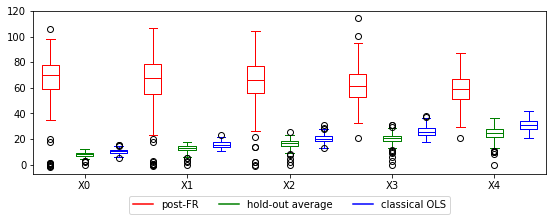

In [31]:
ticks = ['X0', 'X1', 'X2', 'X3', 'X4']

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

fig = plt.figure()

bp1 = plt.boxplot(FR,  positions=np.arange(0,5)*3-1, widths=0.5)
bp2 = plt.boxplot(SL,  positions=np.arange(0,5)*3  , widths=0.5)
bp3 = plt.boxplot(OLS, positions=np.arange(0,5)*3+1, widths=0.5)

set_box_color(bp1, 'r')
set_box_color(bp2, 'g')
set_box_color(bp3, 'b')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='r', label='post-FR')
plt.plot([], c='g', label='hold-out average')
plt.plot([], c='b', label='classical OLS')
plt.legend(bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=5)
plt.xticks(range(0, len(ticks) * 3, 3), ticks)
plt.tight_layout()
fig.set_size_inches(8,3)
fig.savefig('t_value_compare.jpg', dpi=1200)

# save computation results

In [32]:
pkl_file = "./numerical_result/post_solar_test.p"

with open(pkl_file, "wb") as f:
    pickle.dump(df_t  , f)
    pickle.dump(df_p  , f)
    pickle.dump(df_se , f)
    pickle.dump(df_FR , f)
    pickle.dump(df_SL , f)
    pickle.dump(df_OLS, f)
    pickle.dump(FR    , f)
    pickle.dump(SL    , f)
    pickle.dump(OLS   , f)
    print('result saved')

result saved


In [1]:
!rm -rf Example_Post_solar_test.html
!jupyter nbconvert --to html Example_Post_solar_test.ipynb 

[NbConvertApp] Converting notebook Example_Post_solar_test.ipynb to html
[NbConvertApp] Writing 748538 bytes to Example_Post_solar_test.html
